# NHL predictions project - Data Interpretation

This is project for the subject Data Processing in Python - JEM207. That was created by Pavlína Křenková and Vojtěch Vaverka.

The code we wrote scrapes data from the website https://nhl.cz/. After the data is scraped, user of the code needs to fill in names of two teams into the variables team_1 and team_2. Once those two variables are set the code creates a Logistic regression that predicts which team is going to win. Druing our testing of the code we have reached accuracy above 50%. That means that the model is better than randomly guessing. Yet it should not be used to place bets.

In [1]:
from bs4 import BeautifulSoup
from time import sleep
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from statistics import mean

In [2]:
teams_info = pd.read_csv('teams_info/teams_info.csv')
teams_info.head()

,team,code,team_short
0,Anaheim Ducks,/klub/2004,ANA
1,Arizona Coyotes,/klub/2005,ARI
2,Boston Bruins,/klub/1987,BOS
3,Buffalo Sabres,/klub/1989,BUF
4,Calgary Flames,/klub/2006,CGY


In [3]:
dict_team_codes = pd.Series(teams_info.code.values,index=teams_info.team).to_dict()
dict_team_codes

{'Anaheim Ducks': '/klub/2004',
 'Arizona Coyotes': '/klub/2005',
 'Boston Bruins': '/klub/1987',
 'Buffalo Sabres': '/klub/1989',
 'Calgary Flames': '/klub/2006',
 'Carolina Hurricanes': '/klub/1990',
 'Chicago Blackhawks': '/klub/2007',
 'Colorado Avalanche': '/klub/2008',
 'Columbus Blue Jackets': '/klub/1991',
 'Dallas Stars': '/klub/2009',
 'Detroit Red Wings': '/klub/1992',
 'Edmonton Oilers': '/klub/2010',
 'Florida Panthers': '/klub/1993',
 'Los Angeles Kings': '/klub/2011',
 'Minnesota Wild': '/klub/2012',
 'Montreal Canadiens': '/klub/1994',
 'Nashville Predators': '/klub/2013',
 'New Jersey Devils': '/klub/1995',
 'New York Islanders': '/klub/1996',
 'New York Rangers': '/klub/1997',
 'Ottawa Senators': '/klub/1998',
 'Philadelphia Flyers': '/klub/1999',
 'Pittsburgh Penguins': '/klub/2000',
 'San Jose Sharks': '/klub/2014',
 'Seattle Kraken': '/klub/2730',
 'St. Louis Blues': '/klub/2015',
 'Tampa Bay Lightning': '/klub/2001',
 'Toronto Maple Leafs': '/klub/2002',
 'Vancouv

In [4]:
#seasons added manually since there is no system in their encoding
#2017 je 2017/2018 atd.
season_codes = {'2017': '6049', '2018': '6270', '2019': '6494', '2020': '6673','2021': '6733'}
seasons_used = ['2017', '2018', '2019', '2020','2021']

In [5]:
distinct_teams = list(dict_team_codes.keys())

In [6]:
teams_dict = pd.Series(teams_info.team_short.values,index=teams_info.team).to_dict()
teams_dict

{'Anaheim Ducks': 'ANA',
 'Arizona Coyotes': 'ARI',
 'Boston Bruins': 'BOS',
 'Buffalo Sabres': 'BUF',
 'Calgary Flames': 'CGY',
 'Carolina Hurricanes': 'CAR',
 'Chicago Blackhawks': 'CHI',
 'Colorado Avalanche': 'COL',
 'Columbus Blue Jackets': 'CBJ',
 'Dallas Stars': 'DAL',
 'Detroit Red Wings': 'DET',
 'Edmonton Oilers': 'EDM',
 'Florida Panthers': 'FLA',
 'Los Angeles Kings': 'LAK',
 'Minnesota Wild': 'MIN',
 'Montreal Canadiens': 'MTL',
 'Nashville Predators': 'NSH',
 'New Jersey Devils': 'NJD',
 'New York Islanders': 'NYI',
 'New York Rangers': 'NYR',
 'Ottawa Senators': 'OTT',
 'Philadelphia Flyers': 'PHI',
 'Pittsburgh Penguins': 'PIT',
 'San Jose Sharks': 'SJS',
 'Seattle Kraken': 'SEA',
 'St. Louis Blues': 'STL',
 'Tampa Bay Lightning': 'TBL',
 'Toronto Maple Leafs': 'TOR',
 'Vancouver Canucks': 'VAN',
 'Vegas Golden Knights': 'VGK',
 'Washington Capitals': 'WSH',
 'Winnipeg Jets': 'WPG'}

## Choosing two teams and building the model

In [7]:
team_1 = "Tampa Bay Lightning"
team_2 = "Pittsburgh Penguins"
team_1_short = teams_dict[team_1]
team_2_short = teams_dict[team_2]

In [8]:
matches_team_1 = pd.read_csv(f'teams_final/{team_1_short}.csv')
matches_team_1.head()

,game_id,TOI_result,TOI_home,TOI,other_team,TOI_points_tot,TOI_goals_scored_tot,TOI_goals_rec_tot,other_team_points_tot,other_team_goals_scored_tot,other_team_goals_rec_tot
0,/zapas/2526382,1.0,1.0,Tampa Bay Lightning,Chicago Blackhawks,45.0,80.0,52.0,30.0,61.0,53.0
1,/zapas/2526392,0.0,0.0,Tampa Bay Lightning,Washington Capitals,44.0,78.0,51.0,27.0,53.0,63.0
2,/zapas/2526407,0.0,0.0,Tampa Bay Lightning,Pittsburgh Penguins,44.0,75.0,49.0,25.0,52.0,67.0
3,/zapas/2526421,1.0,0.0,Tampa Bay Lightning,Buffalo Sabres,42.0,73.0,51.0,20.0,46.0,65.0
4,/zapas/2526431,0.0,0.0,Tampa Bay Lightning,Boston Bruins,42.0,70.0,47.0,30.0,56.0,59.0


In [9]:
#dropping unnecessary columns
matches_team_1 = matches_team_1.drop(columns=['game_id', 'TOI','other_team'])

#### Defining the independent and dependent variables

In [10]:
#independent
x = matches_team_1.iloc[:, 1:].values
#dependent - the result
y = matches_team_1.iloc[:, 0].values

#### Splitting into training and test set

In [11]:
matches_team_1.iloc[:, 1:]

,TOI_home,TOI_points_tot,TOI_goals_scored_tot,TOI_goals_rec_tot,other_team_points_tot,other_team_goals_scored_tot,other_team_goals_rec_tot
0,1.0,45.0,80.0,52.0,30.0,61.0,53.0
1,0.0,44.0,78.0,51.0,27.0,53.0,63.0
2,0.0,44.0,75.0,49.0,25.0,52.0,67.0
3,0.0,42.0,73.0,51.0,20.0,46.0,65.0
4,0.0,42.0,70.0,47.0,30.0,56.0,59.0
...,...,...,...,...,...,...,...
346,1.0,29.0,64.0,51.0,32.0,67.0,70.0
347,0.0,32.0,69.0,49.0,45.0,85.0,54.0
348,1.0,32.0,75.0,52.0,24.0,60.0,71.0
349,0.0,32.0,75.0,52.0,21.0,55.0,71.0


In [12]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)

In [13]:
X_test[:5]

array([[ 1., 39., 72., 49., 39., 84., 68.],
       [ 1., 34., 73., 68., 41., 76., 58.],
       [ 1., 42., 75., 55., 33., 57., 50.],
       [ 1., 36., 71., 60., 36., 61., 52.],
       [ 0., 47., 91., 57., 23., 52., 59.]])

In [14]:
#rescaling everything except the "home" dummy ... and then adding the dummy back
scaler = StandardScaler()
X_train_stand = scaler.fit_transform(X_train[:,1:])
X_test_stand = scaler.transform(X_test[:,1:])
X_train_stand = np.insert(X_train_stand,0,X_train[:,0],axis=1)
X_test_stand = np.insert(X_test_stand,0,X_test[:,0],axis=1)

#### The model and predictions

In [15]:
reg = LogisticRegression(max_iter = 400)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [16]:
#how well does the model perform?
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[ 1  9]
 [ 2 24]]


In [17]:
print("Accuracy :  \n", accuracy_score(y_test, y_pred))

Accuracy :  
 0.6944444444444444


In [18]:
matches_team_2 = pd.read_csv(f'teams_final/{team_2_short}.csv')
matches_team_2.head()

,game_id,TOI_result,TOI_home,TOI,other_team,TOI_points_tot,TOI_goals_scored_tot,TOI_goals_rec_tot,other_team_points_tot,other_team_goals_scored_tot,other_team_goals_rec_tot
0,/zapas/2526378,0.0,1.0,Pittsburgh Penguins,Vancouver Canucks,31.0,54.0,60.0,30.0,53.0,57.0
1,/zapas/2526388,0.0,0.0,Pittsburgh Penguins,Boston Bruins,28.0,52.0,65.0,30.0,54.0,59.0
2,/zapas/2526407,1.0,1.0,Pittsburgh Penguins,Tampa Bay Lightning,25.0,52.0,67.0,44.0,75.0,49.0
3,/zapas/2526417,1.0,1.0,Pittsburgh Penguins,Philadelphia Flyers,28.0,53.0,64.0,24.0,57.0,63.0
4,/zapas/2526442,1.0,0.0,Pittsburgh Penguins,Buffalo Sabres,27.0,54.0,65.0,20.0,44.0,63.0


### the final prediction

In [19]:
matches_team_1_pre = pd.read_csv(f'teams_pre-processed/{team_1_short}_pre.csv')
matches_team_2_pre = pd.read_csv(f'teams_pre-processed/{team_2_short}_pre.csv')

In [20]:
pred_team_1 = matches_team_1_pre[['TOI_points', 'TOI_goals_scored', 'TOI_goals_rec']].tail(20).sum().values

In [21]:
#je to v poradi points-goals scored-goals received
pred_team_1

array([35., 80., 56.])

In [22]:
pred_team_2 = matches_team_2_pre[['TOI_points', 'TOI_goals_scored', 'TOI_goals_rec']].tail(20).sum().values
pred_team_2

array([27., 71., 63.])

In [23]:
TOI_home = np.array([1])

In [24]:
values_to_fit = np.concatenate([TOI_home, pred_team_1, pred_team_2]).reshape(1, -1)

In [25]:
final_pred = reg.predict(values_to_fit)
final_pred

array([1.])

In [26]:
if final_pred[0] == 1:
    print('The team', team_1, "is predicted to win this game.")
elif final_pred[0] == 0:
    print('The team', team_2, "is predicted to win this game.")
else:
    print('An error occured along the way. Please try again.')

The team Tampa Bay Lightning is predicted to win this game.


## Accuraccy of models of individual teams

In [27]:
#How accurate is the model for individual teams?
accuracies = []
for one_team in distinct_teams:
    one_team_short = teams_dict[one_team]
    matches_one_team = pd.read_csv(f'teams_final/{one_team_short}.csv')
    matches_one_team = matches_one_team.drop(columns=['game_id', 'TOI','other_team'])
    x = matches_one_team.iloc[:, 1:].values
    y = matches_one_team.iloc[:, 0].values
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)

    scaler = StandardScaler()
    X_train_stand = scaler.fit_transform(X_train[:,1:])
    X_test_stand = scaler.transform(X_test[:,1:])
    X_train_stand = np.insert(X_train_stand,0,X_train[:,0],axis=1)
    X_test_stand = np.insert(X_test_stand,0,X_test[:,0],axis=1)
    reg = LogisticRegression(max_iter = 400)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))
    

print((accuracies))
print(sum(acc < 0.5 for acc in accuracies)) #4 teams out of 32 have lower then 0.5 accuracy

[0.5277777777777778, 0.5142857142857142, 0.6944444444444444, 0.6285714285714286, 0.5555555555555556, 0.6, 0.5277777777777778, 0.5555555555555556, 0.4722222222222222, 0.5714285714285714, 0.6388888888888888, 0.6388888888888888, 0.5833333333333334, 0.5555555555555556, 0.6, 0.5277777777777778, 0.5428571428571428, 0.6285714285714286, 0.5142857142857142, 0.45714285714285713, 0.75, 0.5428571428571428, 0.42857142857142855, 0.5, 0.7142857142857143, 0.5277777777777778, 0.6944444444444444, 0.4166666666666667, 0.5142857142857142, 0.6666666666666666, 0.6, 0.5833333333333334]
4


In [28]:
mean(accuracies) #the model is 57% accurate, on average

0.5710565476190476

### Calculating Home Advantage

In [29]:
#ja moc nevim jestli tenhle vypocet je dobre
all_matches = pd.read_csv('all_matches.csv')
sum_wins_home = sum(all_matches["goals_home"] > all_matches["goals_away"])
sum_wins_away = sum(all_matches["goals_home"] < all_matches["goals_away"])
 
home_winrate = sum_wins_home/(sum_wins_home+sum_wins_away)
home_winrate

0.5413507925568574

### calculating and visualising home advantage for all teams for all seasons together

In [30]:
home_advantages = {}
for one_team in distinct_teams:
    one_team_short = teams_dict[one_team]
    matches_one_team = pd.read_csv(f'teams_final/{one_team_short}.csv')
    home_ad = (sum((matches_one_team['TOI_home'] == 1) & (matches_one_team['TOI_result'] == 1)))/sum(matches_one_team['TOI_home'] == 1)
    home_advantages[one_team] = home_ad
    
home_advantages

#add points total, so that we can see if it corresponds

{'Anaheim Ducks': 0.4508670520231214,
 'Arizona Coyotes': 0.42528735632183906,
 'Boston Bruins': 0.6704545454545454,
 'Buffalo Sabres': 0.42134831460674155,
 'Calgary Flames': 0.5375722543352601,
 'Carolina Hurricanes': 0.6149425287356322,
 'Chicago Blackhawks': 0.42857142857142855,
 'Colorado Avalanche': 0.6514285714285715,
 'Columbus Blue Jackets': 0.5284090909090909,
 'Dallas Stars': 0.5795454545454546,
 'Detroit Red Wings': 0.39664804469273746,
 'Edmonton Oilers': 0.5375722543352601,
 'Florida Panthers': 0.6440677966101694,
 'Los Angeles Kings': 0.4797687861271676,
 'Minnesota Wild': 0.6193181818181818,
 'Montreal Canadiens': 0.43258426966292135,
 'Nashville Predators': 0.6022727272727273,
 'New Jersey Devils': 0.41954022988505746,
 'New York Islanders': 0.550561797752809,
 'New York Rangers': 0.5202312138728323,
 'Ottawa Senators': 0.44,
 'Philadelphia Flyers': 0.49714285714285716,
 'Pittsburgh Penguins': 0.6460674157303371,
 'San Jose Sharks': 0.5172413793103449,
 'Seattle Kraken

### calculating and visualising home advantage for individual seasons

In [31]:
home_advantage = pd.DataFrame(seasons_used, columns=['year'])
ha = []
for season in seasons_used:
    ha_one_season = sum(all_matches.loc[all_matches['season'] == int(season)]["home_wins"])/len(all_matches.loc[all_matches['season'] == int(season)]["home_wins"])
    ha.append(round(ha_one_season*100,3))
home_advantage["win_home_percentage"] = ha
home_advantage

,year,win_home_percentage
0,2017,56.334
1,2018,53.659
2,2019,53.327
3,2020,53.341
4,2021,53.659


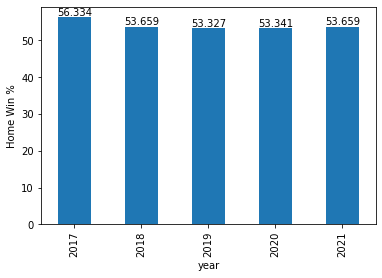

In [32]:
ha = home_advantage.plot(x = 'year', legend=False, kind = "bar")
plt.ylabel("Home Win %")
ha.bar_label(ha.containers[0], labels=home_advantage['win_home_percentage'])
plt.show()

### calculating home advantage for all teams and all seasons

In [33]:
sum(all_matches["home_wins"])/len(all_matches["home_wins"])

0.5413507925568574

### calculating and visualising home advantage for one specific team and all seasons

### After picking 2 teams both their final_dfs are found, saved and displayed

In [34]:
matches_team_1s = pd.read_csv(f'teams_final/{team_1_short}.csv')
matches_between_them = matches_team_1s.merge(matches_team_2, left_on='game_id', right_on='game_id',suffixes=('', '2'))
matches_between_them.drop(columns=['TOI_result2', 'TOI_home2','TOI2','other_team2','TOI_points_tot2','TOI_goals_scored_tot2','TOI_goals_rec_tot2'], inplace=True)
pd.set_option("display.max_rows", None, "display.max_columns", None)
matches_between_them.head()

,game_id,TOI_result,TOI_home,TOI,other_team,TOI_points_tot,TOI_goals_scored_tot,TOI_goals_rec_tot,other_team_points_tot,other_team_goals_scored_tot,other_team_goals_rec_tot,other_team_points_tot2,other_team_goals_scored_tot2,other_team_goals_rec_tot2
0,/zapas/2526407,0.0,0.0,Tampa Bay Lightning,Pittsburgh Penguins,44.0,75.0,49.0,25.0,52.0,67.0,44.0,75.0,49.0
1,/zapas/2647477,1.0,0.0,Tampa Bay Lightning,Pittsburgh Penguins,39.0,73.0,58.0,30.0,68.0,60.0,39.0,73.0,58.0
2,/zapas/2647974,0.0,0.0,Tampa Bay Lightning,Pittsburgh Penguins,46.0,85.0,55.0,37.0,74.0,60.0,46.0,85.0,55.0
3,/zapas/2648046,1.0,1.0,Tampa Bay Lightning,Pittsburgh Penguins,40.0,69.0,53.0,36.0,71.0,58.0,40.0,69.0,53.0
4,/zapas/2806520,1.0,1.0,Tampa Bay Lightning,Pittsburgh Penguins,38.0,82.0,66.0,34.0,59.0,50.0,38.0,82.0,66.0


In [35]:
pd.set_option("display.max_rows", 15, "display.max_columns", 15)

In [36]:
matches_between_them_ids = matches_between_them['game_id']
matches_between_them_ids

0    /zapas/2526407
1    /zapas/2647477
2    /zapas/2647974
3    /zapas/2648046
4    /zapas/2806520
5    /zapas/2807205
6    /zapas/2807246
7    /zapas/2896983
8    /zapas/2897077
9    /zapas/2897849
Name: game_id, dtype: object

### Graphs

#### We create data frames for graphs and we ad variable match_ordr that displays the order of matches of a given team

In [37]:
matches_team_1_graphs = pd.read_csv(f'teams_pre-processed/{team_1_short}_pre.csv')
matches_team_2_graphs = pd.read_csv(f'teams_pre-processed/{team_2_short}_pre.csv')
matches_team_1_graphs['match_ordr'] = range(1, len(matches_team_1_graphs) + 1)
matches_team_2_graphs['match_ordr'] = range(1, len(matches_team_2_graphs) + 1)
matches_team_2_graphs.head()

,game_id,team_home,team_away,goals_home,goals_away,OT,points_home,...,TOI_goals_scored,TOI_goals_rec,TOI_result,other_team,TOI,season,match_ordr
0,/zapas/2526056,Pittsburgh Penguins,St. Louis Blues,4,5,1,1.0,...,4.0,5.0,0.0,St. Louis Blues,Pittsburgh Penguins,2017,1
1,/zapas/2526064,Chicago Blackhawks,Pittsburgh Penguins,10,1,0,3.0,...,1.0,10.0,0.0,Chicago Blackhawks,Pittsburgh Penguins,2017,2
2,/zapas/2526075,Pittsburgh Penguins,Nashville Predators,4,0,0,3.0,...,4.0,0.0,1.0,Nashville Predators,Pittsburgh Penguins,2017,3
3,/zapas/2526101,Washington Capitals,Pittsburgh Penguins,2,3,0,0.0,...,3.0,2.0,1.0,Washington Capitals,Pittsburgh Penguins,2017,4
4,/zapas/2526105,Tampa Bay Lightning,Pittsburgh Penguins,5,4,0,3.0,...,4.0,5.0,0.0,Tampa Bay Lightning,Pittsburgh Penguins,2017,5


### Merge both teams into one dataframe and create a graph of scored goals

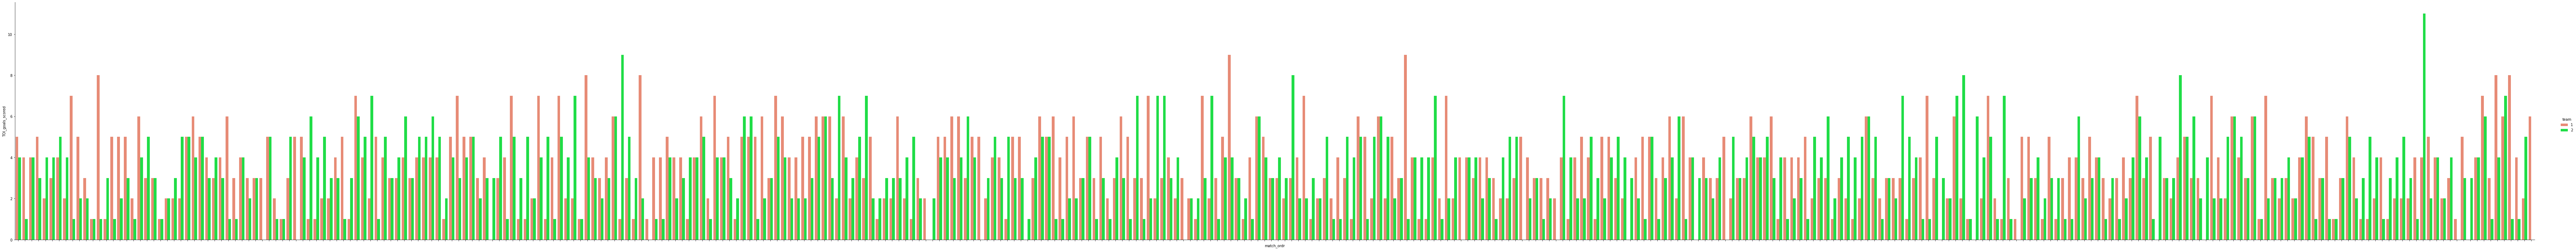

In [38]:
graphs = pd.concat([matches_team_1_graphs, matches_team_2_graphs], axis=0, ignore_index=False)
graphs['team'] = (len(matches_team_1_graphs)*(1,) + len(matches_team_2_graphs)*(2,))
graph_1 = sns.catplot(x='match_ordr', y='TOI_goals_scored', hue='team', kind='bar', data=graphs, height=10, aspect=10, palette=["#FA7F63", "#00FC35"])
graph_1.set(xticklabels=[])
plt.show()

#### Too many matches we need to limit the data to last 30 matches

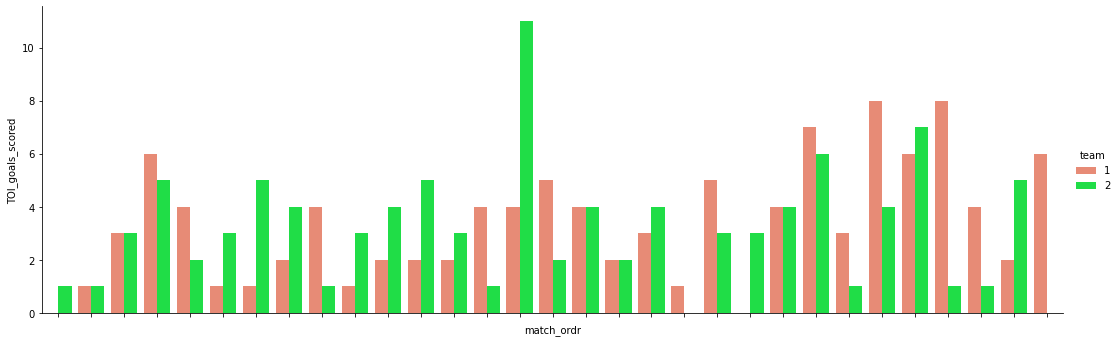

In [39]:
matches_team_1_graphs_30 = matches_team_1_graphs.tail(30)
matches_team_2_graphs_30 = matches_team_2_graphs.tail(30)
graphs_30_matches = pd.concat([matches_team_1_graphs_30, matches_team_2_graphs_30], axis=0, ignore_index=False)
graphs_30_matches['team'] = (len(matches_team_1_graphs_30)*(1,) + len(matches_team_2_graphs_30)*(2,))
graphs_30_matches
graph_2 = sns.catplot(x='match_ordr', y='TOI_goals_scored', hue='team', kind='bar', data=graphs_30_matches, height=5, aspect=3, palette=["#FA7F63", "#00FC35"])
graph_2.set(xticklabels=[])
plt.show()

### Recived Goals

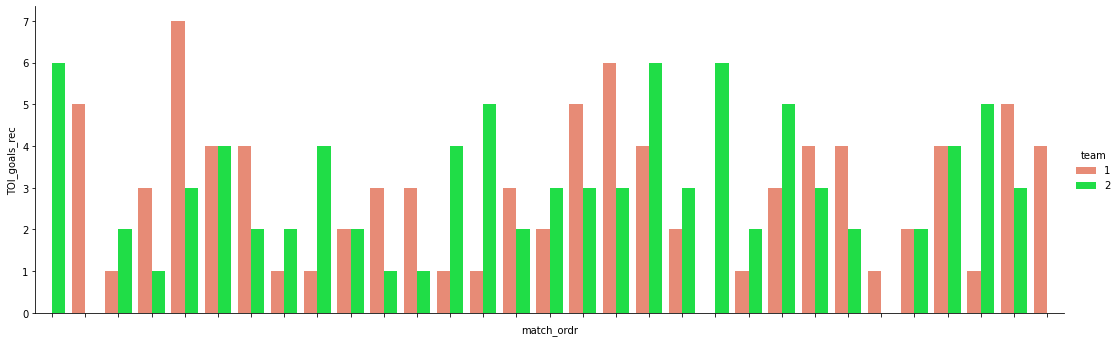

In [40]:
graph_3 = sns.catplot(x='match_ordr', y='TOI_goals_rec', hue='team', kind='bar', data=graphs_30_matches, height=5, aspect=3, palette=["#FA7F63", "#00FC35"])
graph_3.set(xticklabels=[])
plt.show()

### How teams did in last 30 matches

<function matplotlib.pyplot.show(close=None, block=None)>

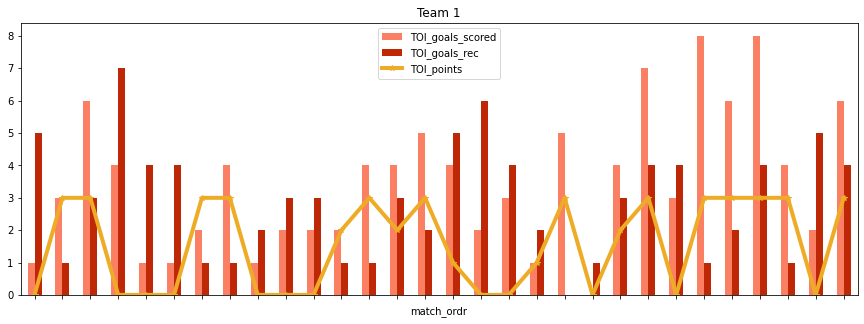

In [41]:
ax = matches_team_1_graphs_30[['TOI_goals_scored','TOI_goals_rec','match_ordr']].plot(
    x='match_ordr',kind='bar',figsize=(15, 5),color=["#FA7F63", "#BF2806"],title='Team 1')
matches_team_1_graphs_30[['TOI_points','match_ordr']].plot(x='match_ordr',  linestyle='-', marker='*',figsize=(15, 5),use_index=False,
                                                   color=["#EEAC26"], lw=4, ax=ax)
ax.set(xticklabels=[])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

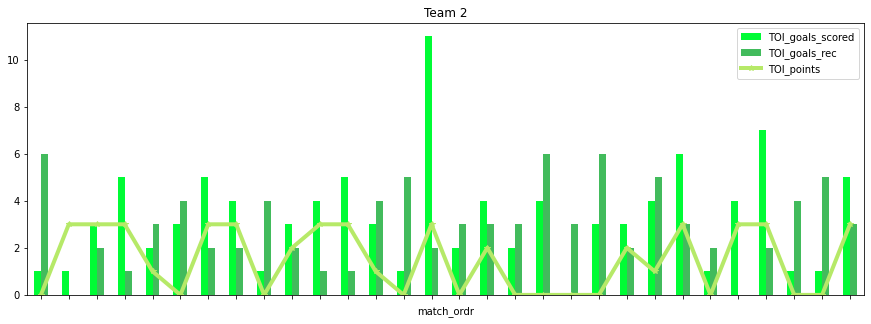

In [42]:
ax = matches_team_2_graphs_30[['TOI_goals_scored','TOI_goals_rec','match_ordr']].plot(
    x='match_ordr',kind='bar',figsize=(15, 5),color=["#00FC35", "#42BB5C"],title='Team 2')
matches_team_2_graphs_30[['TOI_points','match_ordr']].plot(x='match_ordr',  linestyle='-', marker='*',figsize=(15, 5),use_index=False,
                                                   color=["#B6E968"], lw=4, ax=ax)
ax.set(xticklabels=[])
plt.show

### Comparison of important variables for our model

<function matplotlib.pyplot.show(close=None, block=None)>

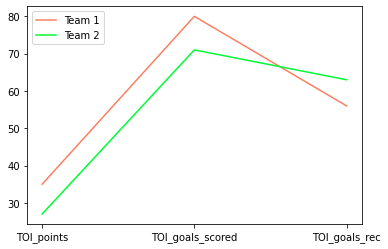

In [43]:
x_coordinates = ['TOI_points', 'TOI_goals_scored', 'TOI_goals_rec']
X_axis = np.arange(len(x_coordinates))
plt.plot(x_coordinates, pred_team_1,'#FA7F63',label="Team 1") 
plt.plot(x_coordinates, pred_team_2,'#00FC35',label="Team 2") 
plt.legend(loc="upper left")
plt.show

### 2nd model based on matches between 2 teams

In [63]:
#TOI = team 1
second_model_mathes_filtered= matches_team_1_pre[matches_team_1_pre.other_team == team_2].copy()
second_model_mathes_filtered['match_ordr'] = range(1, len(second_model_mathes_filtered) + 1)
second_model_mathes_filtered

,game_id,team_home,team_away,goals_home,goals_away,OT,points_home,...,TOI_goals_scored,TOI_goals_rec,TOI_result,other_team,TOI,season,match_ordr
3,/zapas/2526105,Tampa Bay Lightning,Pittsburgh Penguins,5,4,0,3.0,...,5.0,4.0,1.0,Pittsburgh Penguins,Tampa Bay Lightning,2017,1
8,/zapas/2526166,Tampa Bay Lightning,Pittsburgh Penguins,7,1,0,3.0,...,7.0,1.0,1.0,Pittsburgh Penguins,Tampa Bay Lightning,2017,2
22,/zapas/2526407,Pittsburgh Penguins,Tampa Bay Lightning,5,2,0,3.0,...,2.0,5.0,0.0,Pittsburgh Penguins,Tampa Bay Lightning,2017,3
100,/zapas/2647477,Pittsburgh Penguins,Tampa Bay Lightning,3,4,0,0.0,...,4.0,3.0,1.0,Pittsburgh Penguins,Tampa Bay Lightning,2018,4
131,/zapas/2647974,Pittsburgh Penguins,Tampa Bay Lightning,4,2,0,3.0,...,2.0,4.0,0.0,Pittsburgh Penguins,Tampa Bay Lightning,2018,5
136,/zapas/2648046,Tampa Bay Lightning,Pittsburgh Penguins,5,4,0,3.0,...,5.0,4.0,1.0,Pittsburgh Penguins,Tampa Bay Lightning,2018,6
172,/zapas/2806520,Tampa Bay Lightning,Pittsburgh Penguins,3,2,0,3.0,...,3.0,2.0,1.0,Pittsburgh Penguins,Tampa Bay Lightning,2019,7
217,/zapas/2807205,Tampa Bay Lightning,Pittsburgh Penguins,4,2,0,3.0,...,4.0,2.0,1.0,Pittsburgh Penguins,Tampa Bay Lightning,2019,8
220,/zapas/2807246,Pittsburgh Penguins,Tampa Bay Lightning,1,2,1,1.0,...,2.0,1.0,1.0,Pittsburgh Penguins,Tampa Bay Lightning,2019,9
290,/zapas/2896983,Tampa Bay Lightning,Pittsburgh Penguins,2,6,0,0.0,...,2.0,6.0,0.0,Pittsburgh Penguins,Tampa Bay Lightning,2021,10


### 2nd model here we predict winner based on wins and loses in duels between teams

In [45]:
model_2_data = sum(second_model_mathes_filtered.TOI_result)/len(second_model_mathes_filtered.TOI_result)
if model_2_data > 0.5:
  print(team_1,"will win the match")
elif model_2_data < 0.5:
  print(team_2,"will win the match")
elif model_2_data == 0.5:
  print("The game will end as a draw")
else:
  print("our model can not predict the winner as we do not have data  of", team_1,"facing ",team_2)

Tampa Bay Lightning will win the match


###  Another version of 2nd model here we predict winner based on points in duels between teams

In [46]:
model_2_data_b = sum(second_model_mathes_filtered.TOI_points)/(len(second_model_mathes_filtered.TOI_result)*3)
if model_2_data_b > 0.5:
  print(team_1,"will win the match")
elif model_2_data_b < 0.5:
  print(team_2,"will win the match")
elif model_2_data_b == 0.5:
  print("The game will end as a draw")
else:
  print("our model can not predict the winner as we do not have data  of", team_1,"faceing ",team_2)

Tampa Bay Lightning will win the match


### Accuracy


In [47]:
second_model_mathes_filtered_accuracy = second_model_mathes_filtered.iloc[:-1 , :] #we prepare a data set without the last match
second_model_mathes_filtered_accuracy 

,game_id,team_home,team_away,goals_home,goals_away,OT,points_home,...,TOI_goals_scored,TOI_goals_rec,TOI_result,other_team,TOI,season,match_ordr
3,/zapas/2526105,Tampa Bay Lightning,Pittsburgh Penguins,5,4,0,3.0,...,5.0,4.0,1.0,Pittsburgh Penguins,Tampa Bay Lightning,2017,1
8,/zapas/2526166,Tampa Bay Lightning,Pittsburgh Penguins,7,1,0,3.0,...,7.0,1.0,1.0,Pittsburgh Penguins,Tampa Bay Lightning,2017,2
22,/zapas/2526407,Pittsburgh Penguins,Tampa Bay Lightning,5,2,0,3.0,...,2.0,5.0,0.0,Pittsburgh Penguins,Tampa Bay Lightning,2017,3
100,/zapas/2647477,Pittsburgh Penguins,Tampa Bay Lightning,3,4,0,0.0,...,4.0,3.0,1.0,Pittsburgh Penguins,Tampa Bay Lightning,2018,4
131,/zapas/2647974,Pittsburgh Penguins,Tampa Bay Lightning,4,2,0,3.0,...,2.0,4.0,0.0,Pittsburgh Penguins,Tampa Bay Lightning,2018,5
136,/zapas/2648046,Tampa Bay Lightning,Pittsburgh Penguins,5,4,0,3.0,...,5.0,4.0,1.0,Pittsburgh Penguins,Tampa Bay Lightning,2018,6
172,/zapas/2806520,Tampa Bay Lightning,Pittsburgh Penguins,3,2,0,3.0,...,3.0,2.0,1.0,Pittsburgh Penguins,Tampa Bay Lightning,2019,7
217,/zapas/2807205,Tampa Bay Lightning,Pittsburgh Penguins,4,2,0,3.0,...,4.0,2.0,1.0,Pittsburgh Penguins,Tampa Bay Lightning,2019,8
220,/zapas/2807246,Pittsburgh Penguins,Tampa Bay Lightning,1,2,1,1.0,...,2.0,1.0,1.0,Pittsburgh Penguins,Tampa Bay Lightning,2019,9
290,/zapas/2896983,Tampa Bay Lightning,Pittsburgh Penguins,2,6,0,0.0,...,2.0,6.0,0.0,Pittsburgh Penguins,Tampa Bay Lightning,2021,10


In [48]:
second_model_mathes_filtered_result = second_model_mathes_filtered.tail(1) #the result of last match we are checking against
second_model_mathes_filtered_result

,game_id,team_home,team_away,goals_home,goals_away,OT,points_home,...,TOI_goals_scored,TOI_goals_rec,TOI_result,other_team,TOI,season,match_ordr
342,/zapas/2897849,Tampa Bay Lightning,Pittsburgh Penguins,1,5,0,0.0,...,1.0,5.0,0.0,Pittsburgh Penguins,Tampa Bay Lightning,2021,12


In [49]:
second_model_mathes_filtered.head(1)

,game_id,team_home,team_away,goals_home,goals_away,OT,points_home,...,TOI_goals_scored,TOI_goals_rec,TOI_result,other_team,TOI,season,match_ordr
3,/zapas/2526105,Tampa Bay Lightning,Pittsburgh Penguins,5,4,0,3.0,...,5.0,4.0,1.0,Pittsburgh Penguins,Tampa Bay Lightning,2017,1


### Another try at accuracy

In [64]:
wins_before_this_match = []
points_before_this_match = []
matches_before_this_match = []
for x in second_model_mathes_filtered['match_ordr']:
    wins_before_this_match.append(second_model_mathes_filtered[(second_model_mathes_filtered['match_ordr'] < x)]['TOI_result'].sum())
    points_before_this_match.append(second_model_mathes_filtered[(second_model_mathes_filtered['match_ordr'] < x)]['TOI_points'].sum())
    matches_before_this_match.append(second_model_mathes_filtered[(second_model_mathes_filtered['match_ordr'] < x)]['TOI_points'].count())

second_model_mathes_filtered['wins_before_this_match'] = wins_before_this_match
second_model_mathes_filtered['points_before_this_match'] = points_before_this_match
second_model_mathes_filtered['matches_before_this_match'] = matches_before_this_match
second_model_mathes_filtered

,game_id,team_home,team_away,goals_home,goals_away,OT,points_home,...,other_team,TOI,season,match_ordr,wins_before_this_match,points_before_this_match,matches_before_this_match
3,/zapas/2526105,Tampa Bay Lightning,Pittsburgh Penguins,5,4,0,3.0,...,Pittsburgh Penguins,Tampa Bay Lightning,2017,1,0.0,0.0,0
8,/zapas/2526166,Tampa Bay Lightning,Pittsburgh Penguins,7,1,0,3.0,...,Pittsburgh Penguins,Tampa Bay Lightning,2017,2,1.0,3.0,1
22,/zapas/2526407,Pittsburgh Penguins,Tampa Bay Lightning,5,2,0,3.0,...,Pittsburgh Penguins,Tampa Bay Lightning,2017,3,2.0,6.0,2
100,/zapas/2647477,Pittsburgh Penguins,Tampa Bay Lightning,3,4,0,0.0,...,Pittsburgh Penguins,Tampa Bay Lightning,2018,4,2.0,6.0,3
131,/zapas/2647974,Pittsburgh Penguins,Tampa Bay Lightning,4,2,0,3.0,...,Pittsburgh Penguins,Tampa Bay Lightning,2018,5,3.0,9.0,4
136,/zapas/2648046,Tampa Bay Lightning,Pittsburgh Penguins,5,4,0,3.0,...,Pittsburgh Penguins,Tampa Bay Lightning,2018,6,3.0,9.0,5
172,/zapas/2806520,Tampa Bay Lightning,Pittsburgh Penguins,3,2,0,3.0,...,Pittsburgh Penguins,Tampa Bay Lightning,2019,7,4.0,12.0,6
217,/zapas/2807205,Tampa Bay Lightning,Pittsburgh Penguins,4,2,0,3.0,...,Pittsburgh Penguins,Tampa Bay Lightning,2019,8,5.0,15.0,7
220,/zapas/2807246,Pittsburgh Penguins,Tampa Bay Lightning,1,2,1,1.0,...,Pittsburgh Penguins,Tampa Bay Lightning,2019,9,6.0,18.0,8
290,/zapas/2896983,Tampa Bay Lightning,Pittsburgh Penguins,2,6,0,0.0,...,Pittsburgh Penguins,Tampa Bay Lightning,2021,10,7.0,20.0,9


### model based on wins and loses in duels between teams

In [51]:
model_2_data_acc = sum(second_model_mathes_filtered_accuracy.TOI_result)/len(second_model_mathes_filtered_accuracy.TOI_result)
#model_2_data_acc
toi_result = second_model_mathes_filtered_result.iloc[0]['TOI_result']
toi_result

0.0

In [52]:

if len(second_model_mathes_filtered_accuracy) == 0:
    print('Not enough data to predict') 
elif ((toi_result == 1) & (model_2_data_acc > 0.5)):
     print('Prediction would be correct for prevoius duel')
elif ((toi_result == 1) & (model_2_data_acc <= 0.5)):
     print("Prediction would NOT be correct for prevoius duel")
elif ((toi_result == 0) & (model_2_data_acc < 0.5)):
     print('Prediction would be correct for prevoius duel')
elif ((toi_result == 0) & (model_2_data_acc >= 0.5)):
     print("Prediction would NOT be correct for prevoius duel")
else:
     print('We dont have enoug data for this model to work')


Prediction would NOT be correct for prevoius duel


### model based on wins and loses in duels between teams

In [53]:
model_2_data_b_acc = sum(second_model_mathes_filtered_accuracy.TOI_points)/(len(second_model_mathes_filtered_accuracy.TOI_result)*3)
model_2_data_b_acc

0.696969696969697

In [54]:
if len(second_model_mathes_filtered_accuracy) == 0:
    print('Not enough data to predict') 
elif ((toi_result == 1) & (model_2_data_b_acc > 0.5)):
     print('Prediction would be correct for prevoius duel')
elif ((toi_result == 1) & (model_2_data_b_acc <= 0.5)):
     print("Prediction would NOT be correct for prevoius duel")
elif ((toi_result == 0) & (model_2_data_b_acc < 0.5)):
     print('Prediction would be correct for prevoius duel')
elif ((toi_result == 0) & (model_2_data_b_acc >= 0.5)):
     print("Prediction would NOT be correct for prevoius duel")
else:
     print('We dont have enoug data for this model to work')

Prediction would NOT be correct for prevoius duel
